# Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load logins file
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# Check for NaNs
logins_df.isna().sum()

login_time    0
dtype: int64

In [4]:
# Check general info
logins_df.describe()

<ipython-input-4-fc6273851430>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  logins_df.describe()


,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


Most of the login times are unique, and there is data from a little more than 3 months ranging from January 1970 to mid-April 1970.

# Aggregate data based on 15 minute time intervals

In [5]:
# Set the login time as index
logins_df.set_index('login_time', inplace=True)

# Add a count column for each time interval
logins_df['count'] = 1

# resample the login data in 15 minute intervals
logins_df = logins_df.resample('15T').sum()

logins_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


# EDA

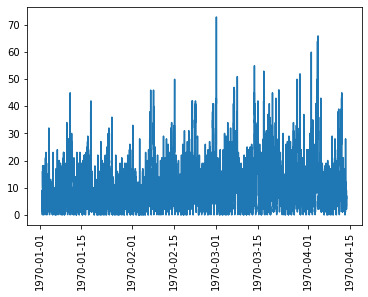

In [6]:
# First look at the data
plt.plot(logins_df)
plt.xticks(rotation=90);

Immediately there appears to be some seasonality to the login data.  There are somewhat equally spaced peaks which may correspond to certain days of the week or certain time periods.  A closer look will help pull out any trends.

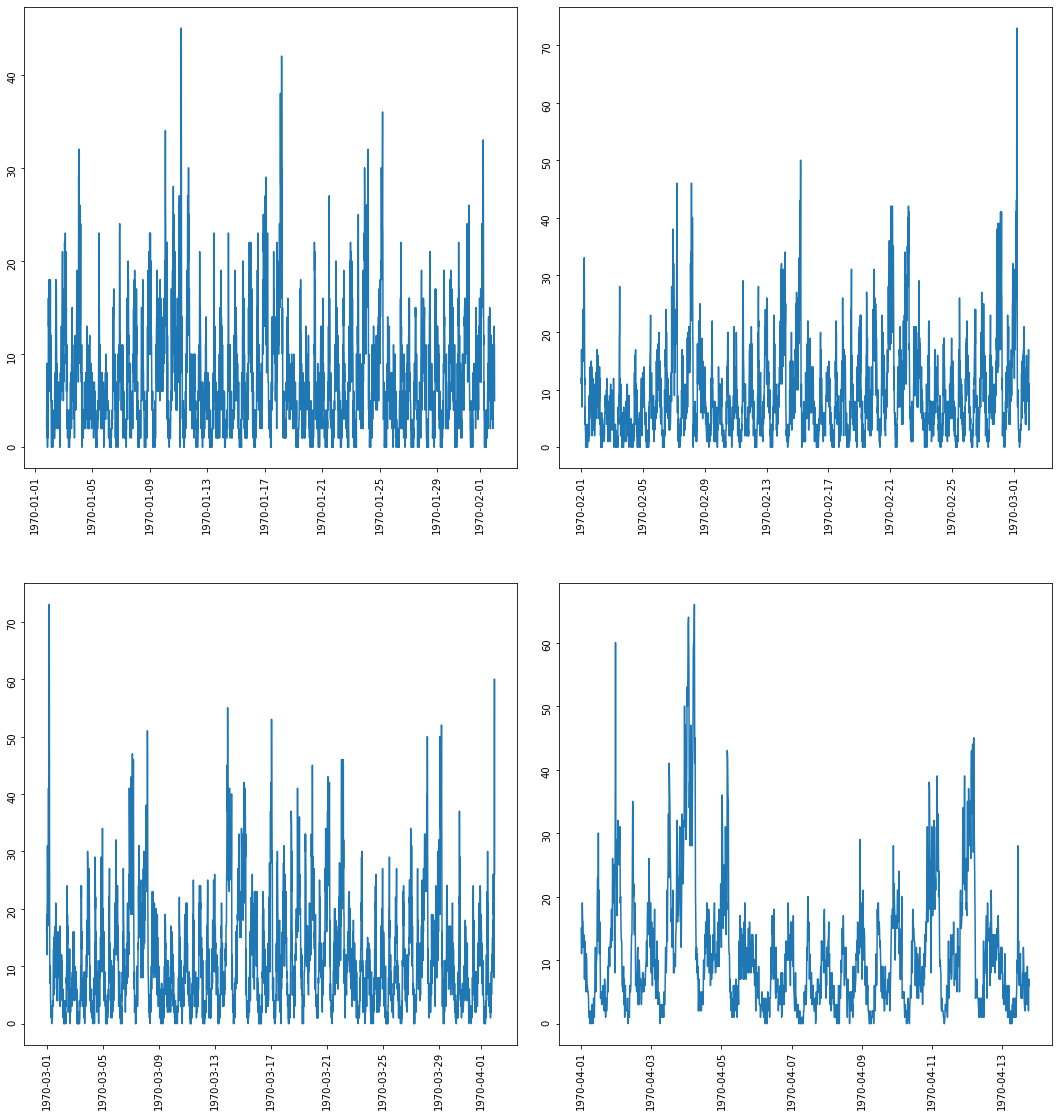

In [7]:
# Plot each month
fig, ax = plt.subplots(2,2, figsize=(15,15))
plt.tight_layout()

ax[0,0].plot(logins_df['1970-01-01':'1970-02-01'])
ax[0,1].plot(logins_df['1970-02-01':'1970-03-01'])
ax[1,0].plot(logins_df['1970-03-01':'1970-04-01'])
ax[1,1].plot(logins_df['1970-04-01':'1970-05-01'])

ax[0,0].tick_params(labelrotation=90)
ax[0,1].tick_params(labelrotation=90)
ax[1,0].tick_params(labelrotation=90)
ax[1,1].tick_params(labelrotation=90)

fig.subplots_adjust(hspace=0.25)

plt.show()

The above plots show that there is a pattern in each month, more clearly in January and February than in March.  Since there is only data for the first half of the month in April the x-axis is a different scale and the pattern looks different.

Looking closer at weeks and specific days will help to zoom in on the pattern.

In [8]:
# Convert dates to datetime since they are currently int64
logins_df.index = pd.to_datetime(logins_df.index.astype(str), format='%Y-%m-%d %H:%M:%S')
logins_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [9]:
type(logins_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [10]:
# Add a day_str and day_int column
logins_df['day_str'] = logins_df.index.day_name()
logins_df['day_int'] = logins_df.index.to_series().dt.dayofweek

logins_df.head()

,count,day_str,day_int
login_time,,,
1970-01-01 20:00:00,2,Thursday,3
1970-01-01 20:15:00,6,Thursday,3
1970-01-01 20:30:00,9,Thursday,3
1970-01-01 20:45:00,7,Thursday,3
1970-01-01 21:00:00,1,Thursday,3


In [11]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days:
    total = sum(logins_df[logins_df['day_str']==day]['count'])
    print('The total number of logins on ' + day + ' is ' + str(total))

The total number of logins on Monday is 8823
The total number of logins on Tuesday is 9268
The total number of logins on Wednesday is 10339
The total number of logins on Thursday is 11960
The total number of logins on Friday is 15208
The total number of logins on Saturday is 19377
The total number of logins on Sunday is 18167


Based on the totals, it seems like there is an increase in logins on the weekends (Friday through Sunday) and not so many on the weekdays, especially early in the week.

In [12]:
# Define a function to color each day of the week when plotting
def easy_plot(df, title):
    
    '''This function resamples the dataframe based on the day of the week and color codes a plot.
    All weekdays will be blue and all weekends will be red'''

    # Loop over each day for which there is data, in ascending order
    for day in sorted(list(df['day_int'].unique())):

        # Create day_df, a subset of the df for the specific day
        day_df = df[df['day_int'] == day]
        
        # Resample so that the plot does not interpolate missing values
        day_df = day_df.resample('15T').sum()
        
        # Set color to blue for Monday, Tuesday, Wednesday, and Thursday
        if day in [0,1,2,3]:
                color = 'blue'
            
        # Set color to red for Friday, Saturday, and Sunday
        else:
            color = 'red'
                
        # Plot data colored by weekday or weekend
        plt.plot(day_df, color=color)
        plt.title(title)
        plt.xticks(rotation=45)

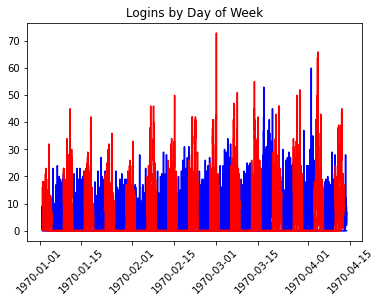

In [13]:
easy_plot(logins_df, title='Logins by Day of Week')

The above plot confirms that the number of logins tends to increase each weekend.  This is true for the entire 4 month period. Now that the day to day trend is clear, individual times of day need to be investigated to see if certain times are more popular than others.

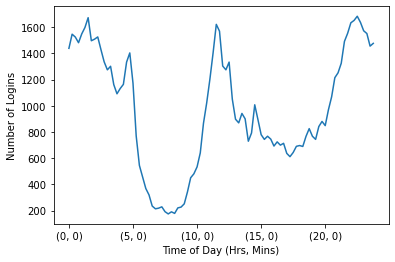

In [14]:
# Plot overall distribution of logins in each 15 minute interval
times = logins_df.index
test = logins_df.groupby([times.hour, times.minute]).sum()

test['count'].plot()
plt.ylabel('Number of Logins')
plt.xlabel('Time of Day (Hrs, Mins)')
plt.show()

In general, most logins occur either late at night between the hours of 10:00 PM and 5:00 AM, or mid-day at about 12:00 PM.

In [15]:
# Define a function to plot the number of logins in each 15 minute interval for each day

def logins_by_day(df, day_int, day_str):
    
    '''This function plots the number of logins at each time interval for the specified day.'''
    
    # Select only the data corresponding to the specified day
    day_df = df[df['day_int'] == day_int]
    
    # Group the data by 15 minute intervals
    times = day_df.index
    day_df = day_df.groupby([times.hour, times.minute]).sum()
    

    day_df['count'].plot()
    plt.ylabel('Number of Logins')
    plt.xlabel('Time of Day (Hrs, Mins)')
    plt.title(day_str)
    plt.show()   

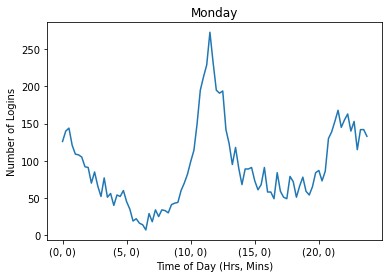

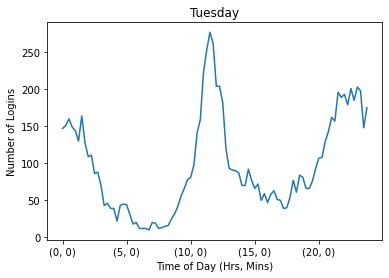

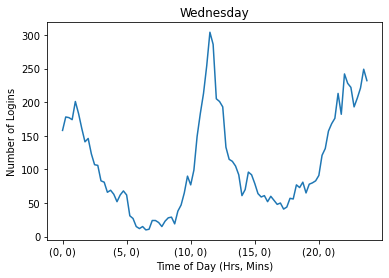

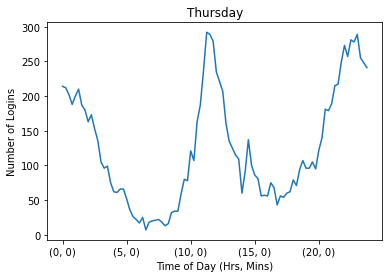

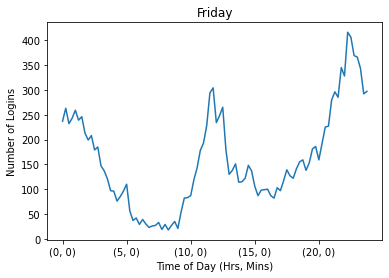

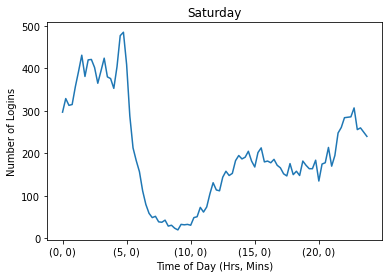

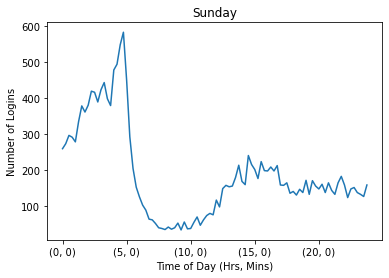

In [16]:
logins_by_day(logins_df, 0, 'Monday')
logins_by_day(logins_df, 1, 'Tuesday')
logins_by_day(logins_df, 2, 'Wednesday')
logins_by_day(logins_df, 3, 'Thursday')
logins_by_day(logins_df, 4, 'Friday')
logins_by_day(logins_df, 5, 'Saturday')
logins_by_day(logins_df, 6, 'Sunday')

# Conclusions

## Weekdays vs Weekends

Demand during weekends is higher than demand during weekdays.  The plot of login counts over the course of nearly 4 months shows a re-occuring peak during the weekends, here defined as Friday, Saturday, and Sunday.

## Time of Day

#### Weekdays
During the week, demand is consistently highest at mid-day (around noon).  There is also an increase in demand late at night (between 8:00 PM and 1:00 AM).

#### Weekends
During the weekend, demand is highest late and night into the early morning (between midnight and 5:00 AM).  Friday is a mixture of the weekdays and weekend because it does have a noticeable peak at mid-day, but most of the demand occurs late at night, leading into the early morning hours of Saturday.